In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

sns.set()

%matplotlib inline

from sklearn.multiclass import OneVsRestClassifier
import xgboost

from src.model import get_xgb_model, fit_model, predict_proba, predict_ordered_list, evaluate_result
from src.feature_engineering import enhance_with_timeseries_features, enhance_with_date_features
from src.clean_dataset import get_prediction_features, reduce_train
from src.metrics import mapk, transform_y

In [2]:
train_X = pd.read_pickle('generated_files/120K/train_X.pkl')
train_Y = pd.read_pickle('generated_files/120K/train_Y.pkl')

test_X = pd.read_pickle('generated_files/120K/test_X.pkl')
test_Y = pd.read_pickle('generated_files/120K/test_Y.pkl')

In [3]:
prediction_features = get_prediction_features(train_X)

enhance_with_timeseries_features(train_X, prediction_features)
enhance_with_date_features(train_X)

enhance_with_timeseries_features(test_X, prediction_features)
enhance_with_date_features(test_X)

In [4]:
X_tr_reduced, Y_tr_reduced = reduce_train(train_X, train_Y)
X_ts_reduced, Y_ts_reduced = reduce_train(test_X, test_Y)

In [20]:
model = get_xgb_model()

In [21]:
fit_model(model, X_tr_reduced, Y_tr_reduced)

In [22]:
probas = predict_proba(model, X_ts_reduced, prediction_features)
ordered_lists = predict_ordered_list(probas)
evaluate_result(ordered_lists, Y_ts_reduced)

0.8700227604877933

Text(0.5, 1, 'Feature Importances Found By XGBoost')

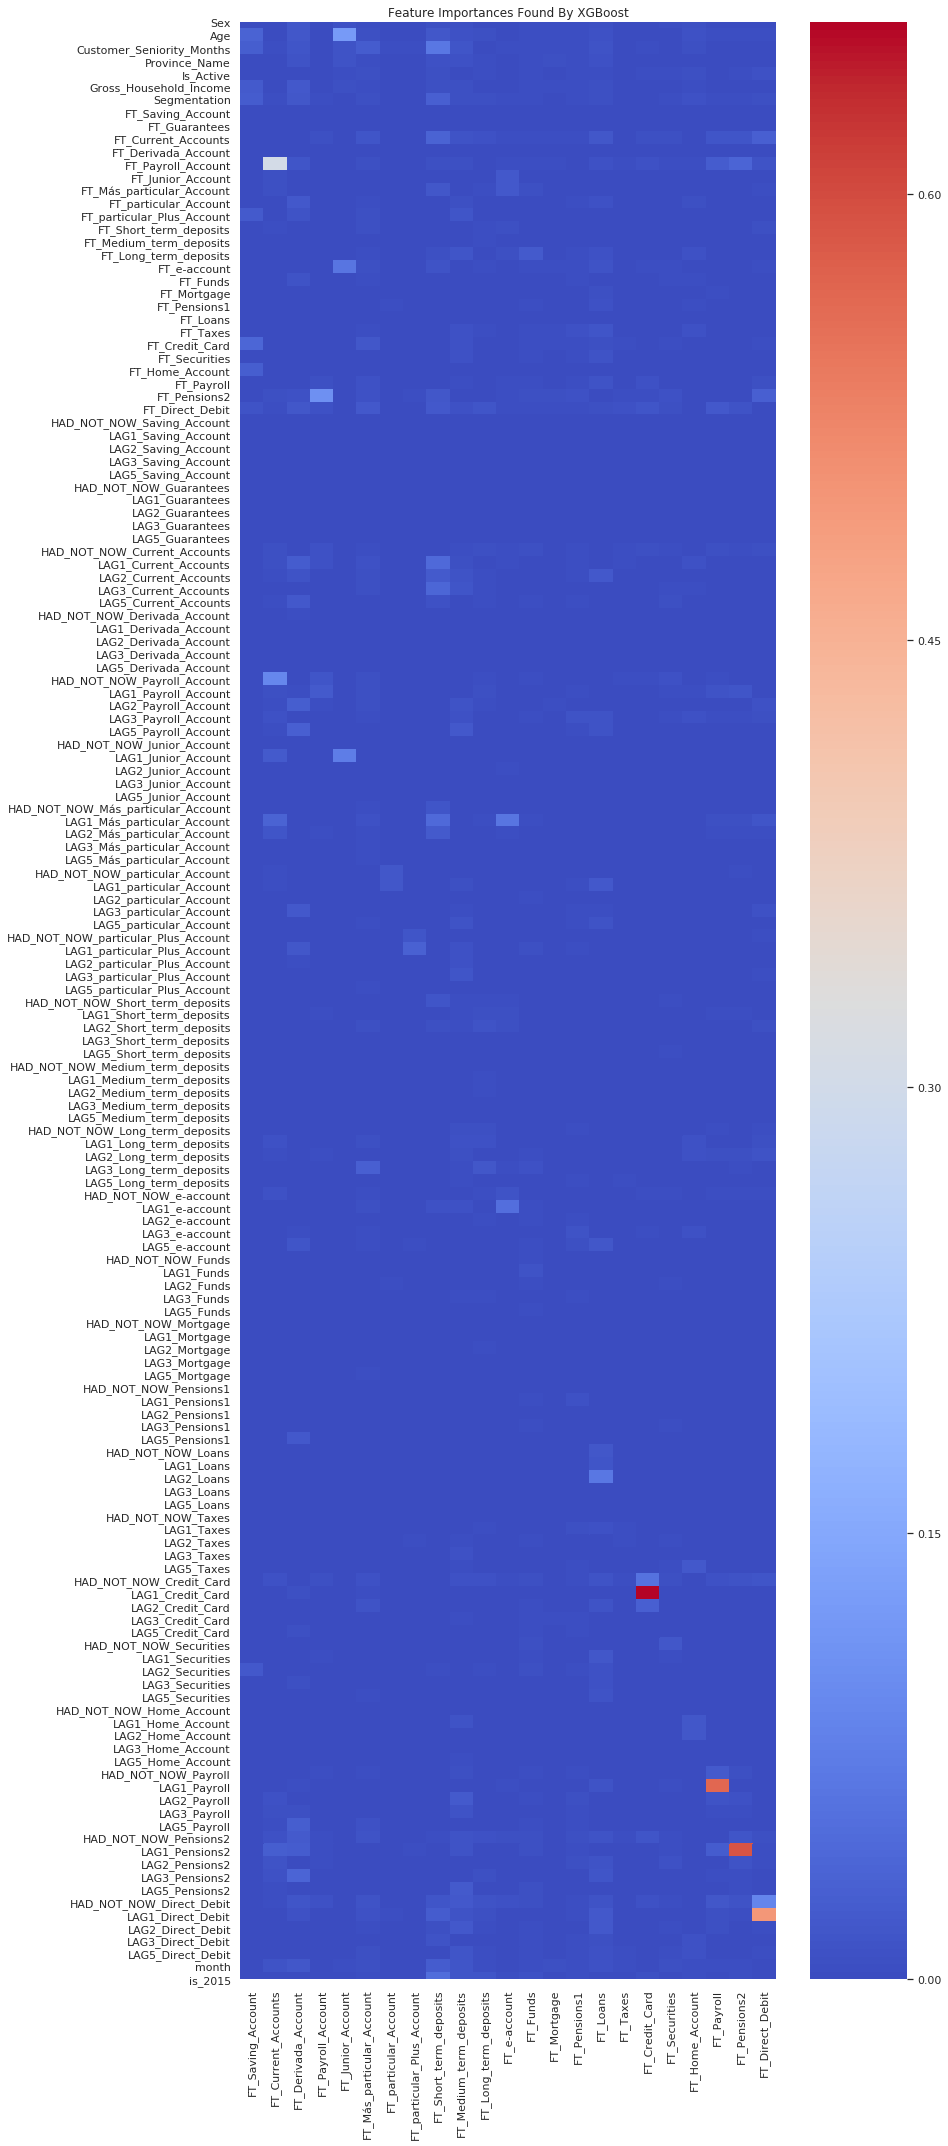

In [49]:
estimators = [(est, col) for est, col in zip(model.estimators_, prediction_features) if est.__class__ == xgboost.XGBClassifier]
fts = train_X.drop(['Customer_Code', 'Row_Date'], axis=1).columns
preds = [p for _,p in estimators]

feature_importances = pd.DataFrame(np.array([est.feature_importances_ for est, _ in estimators]), columns=fts, index=preds)

for p in preds:
    feature_importances.loc[p, p] = 0

sns.set(rc={'figure.figsize':(12,36)})
sns.heatmap(feature_importances.T, cmap='coolwarm').set_title('Feature Importances Found By XGBoost')

In [8]:
dates = pd.Series(X_ts_reduced['Row_Date'].unique()).sort_values().values
results = []

for d in dates:
    test_last_month = X_ts_reduced['Row_Date'] == d
    X_ts_last = X_ts_reduced[test_last_month]
    Y_ts_last = Y_ts_reduced[test_last_month]

    probas = predict_proba(model, X_ts_last, prediction_features)
    ordered_lists = predict_ordered_list(probas)
    results.append(evaluate_result(ordered_lists, Y_ts_last))
    
print("min accuracy:", min(results))
print("max accuracy:", max(results))
print("mean accuracy:", np.array(results).mean())

min accuracy: 0.789838188733771
max accuracy: 0.9046594158496731
mean accuracy: 0.868690177303804


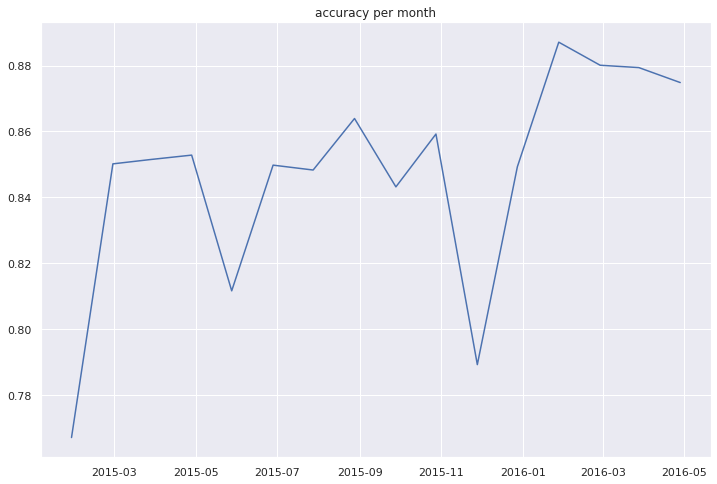

In [73]:
plt.figure(figsize=(12,8))
plt.title("accuracy per month")
plt.plot(dates, results)

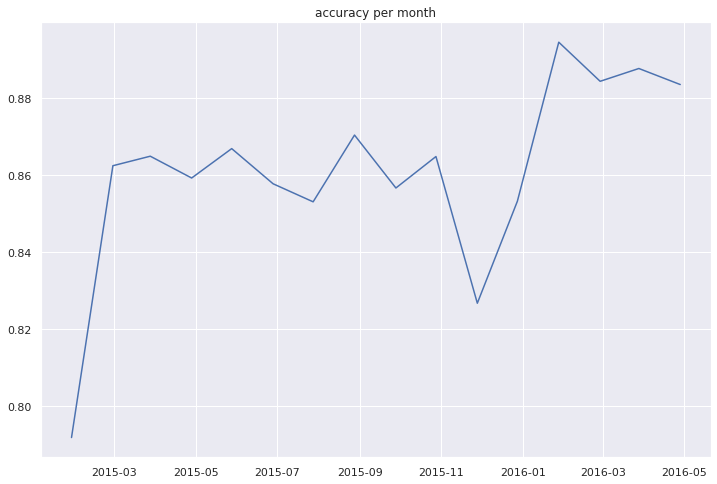

In [9]:
plt.figure(figsize=(12,8))
plt.title("accuracy per month")
plt.plot(dates, results)

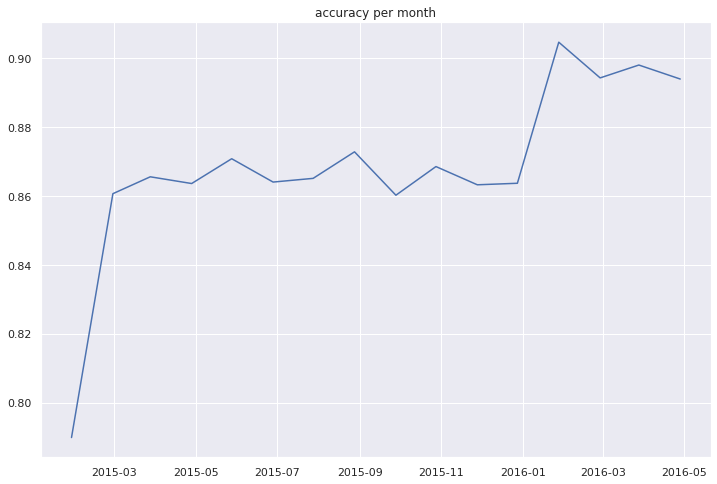

In [9]:
plt.figure(figsize=(12,8))
plt.title("accuracy per month")
plt.plot(dates, results)